# Search precursor for optimal time window

In [1]:
import pandas as pd
import numpy as np
import io
import scipy as sp
import scipy.fftpack
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz, filtfilt, cheby2
import scipy.io as sio
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.font_manager import FontProperties

In [2]:
# Plot standardize
def showplot(axis=0,ls=1.5):
    plt.rcParams.update({'font.size': 18})
    #### Get handles and print plot ####
    handles, labels = ax[axis].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(ls, 0.6),frameon=False,prop={'size': 14})
    for i,a in enumerate(ax):
        #a.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.5)
        a.minorticks_on()
        #a.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
        a.grid(True)
        #for tick in a.get_xticklabels():
        #    tick.set_fontname("Open Sans")
        #for tick in a.get_yticklabels():
        #    tick.set_fontname("Open Sans")
    fig.tight_layout()
    plt.show()

## Load Precursor Data

In [3]:
amrdir          = '/gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03_newWD/post_processing/'
probefile       = amrdir+'/metmast_40000.nc'

# Load in met mast data and interpolate to integer locations
ncdata   = Dataset(probefile,'r')
numPoints = len(ncdata['metmast_T1']['coordinates'][:,1])
numTime   = len(ncdata['time'][:])

time_values = ncdata['time']
coordinates = ncdata['metmast_T1']['coordinates']
velocityx   = ncdata['metmast_T1']['velocityx']
velocityy   = ncdata['metmast_T1']['velocityy']
velocityz   = ncdata['metmast_T1']['velocityz']

# interpolate met mast data
z_locations = [26.5,90,153.5]
interpolated_velocityx = np.zeros((numTime,len(z_locations)))
interpolated_velocityy = np.zeros((numTime,len(z_locations)))
interpolated_velocityz = np.zeros((numTime,len(z_locations)))
for i in range(numTime):
    interpolatorx = interp1d(coordinates[:,-1],velocityx[i,:],kind='linear')
    interpolatory = interp1d(coordinates[:,-1],velocityy[i,:],kind='linear')
    interpolatorz = interp1d(coordinates[:,-1],velocityz[i,:],kind='linear')

    interpolated_velocityx[i,:] = interpolatorx(z_locations)
    interpolated_velocityy[i,:] = interpolatory(z_locations)
    interpolated_velocityz[i,:] = interpolatorz(z_locations)
    
numPoints = 3
fullData = np.zeros((numTime*numPoints,7))
for i in range(numTime):
    fullData[i*numPoints:(i+1)*numPoints, 0] = time_values[i]
    fullData[i*numPoints:(i+1)*numPoints, 1] = coordinates[0,0] #fixed x
    fullData[i*numPoints:(i+1)*numPoints, 2] = coordinates[0,1] #fixed y
    fullData[i*numPoints:(i+1)*numPoints, 3] = z_locations
    fullData[i*numPoints:(i+1)*numPoints, 4] = interpolated_velocityx[i,:]
    fullData[i*numPoints:(i+1)*numPoints, 5] = interpolated_velocityy[i,:]
    fullData[i*numPoints:(i+1)*numPoints, 6] = interpolated_velocityz[i,:]



In [4]:
columns  = ['Time','coordinates[0]','coordinates[1]','coordinates[2]','velocity_probe[0]','velocity_probe[1]','velocity_probe[2]']
precData = {}
precData['run1'] = pd.DataFrame(fullData,columns=columns)
precData['run1']

,Time,coordinates[0],coordinates[1],coordinates[2],velocity_probe[0],velocity_probe[1],velocity_probe[2]
0,20000.0,2000.0,2560.0,26.5,4.832855,0.528418,-0.135985
1,20000.0,2000.0,2560.0,90.0,6.129392,0.547908,0.168858
2,20000.0,2000.0,2560.0,153.5,6.675924,0.271690,-0.003882
3,20000.5,2000.0,2560.0,26.5,4.819696,0.535112,-0.134528
4,20000.5,2000.0,2560.0,90.0,6.150282,0.539144,0.178958
...,...,...,...,...,...,...,...
29998,24999.5,2000.0,2560.0,90.0,6.597191,0.785456,-0.119684
29999,24999.5,2000.0,2560.0,153.5,6.303538,0.896122,0.324967
30000,25000.0,2000.0,2560.0,26.5,4.482639,0.793769,-0.090551
30001,25000.0,2000.0,2560.0,90.0,6.620821,0.771440,-0.146470


## Search Precursor Data

In [5]:
#############################################
### User Input 
#############################################
prData = precData['run1']

dt = 0.5       # sim output time step
it = precData['run1'].Time[0]    # initial time
nt = len(np.array(prData['Time'][(prData['coordinates[2]']==z_locations[1])]))  # number of timesteps
#nt = len(np.array(prData['Time']))
print("nt: ",nt)
bt = 15       # bin time length in minutes
bl = bt*60/dt  # steps per bin
ol = 1        # steps to skip ahead in search

expU = 6.265 # match the LowWS_LowTI condition
expShear = 0.11622
expTI = 0.098221
expWD = 265.6718
expVeer = 20.9

#############################################

# Load precursor data
#prKsgs = prData['turbulent_ke_probe[0]']
prU = prData['velocity_probe[0]']
prV = prData['velocity_probe[1]']
prW = prData['velocity_probe[2]']
prH = prData['coordinates[2]']
prT = np.array(prData['Time'][(prH==z_locations[1])])

dx_range = 0.0001

H_low = z_locations[0]
U_low = np.array(prU[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
V_low = np.array(prV[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
W_low = np.array(prW[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
Umag_low = np.sqrt(U_low**2 + V_low**2)

H_high = z_locations[2]
U_high = np.array(prU[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
V_high = np.array(prV[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
W_high = np.array(prW[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
Umag_high = np.sqrt(U_high**2 + V_high**2)

H_hh = z_locations[1]
U_hh = np.array(prU[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
V_hh = np.array(prV[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
W_hh = np.array(prW[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
Umag_hh = np.sqrt(U_hh**2 + V_hh**2)

# Log law alpha - two point
alpha_inst = np.log(Umag_high/Umag_low)/np.log(H_high/H_low)

# Log law alpha - 3 point fit 
alpha_fit = np.zeros_like(alpha_inst)
def alpha_fit_fun(x,a,b):
    return b*x**a
umag_fit = np.asarray([Umag_low,Umag_hh,Umag_high])
z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
for i in range(0,umag_fit.shape[1]):
    popt,pcov  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,umag_fit[:,i])
    alpha_fit[i]  = popt[0]

#hub height wind direction
veer_fit = np.zeros_like(alpha_inst)
def veer_fit_fun(x,a,b):
    return a*x+b
windDir_hh = 270-np.arctan2(V_hh, U_hh)*180.0/np.pi
windDir_low = 270-np.arctan2(V_low, U_low)*180.0/np.pi
windDir_high = 270-np.arctan2(V_high, U_high)*180.0/np.pi
wind_dir_fit = np.asarray([windDir_low,windDir_hh,windDir_high])
for i in range(0,wind_dir_fit.shape[1]):
    popt,pcov  = sp.optimize.curve_fit(veer_fit_fun,z_fit,wind_dir_fit[:,i])
    veer_fit[i]  = popt[0]*(H_high-H_low)
        
# Velocity Fluctuations
Up_low = U_low-np.mean(U_low)
Vp_low = V_low-np.mean(V_low)
Wp_low = W_low-np.mean(W_low)
kres_low = 0.5*(Up_low**2 + Vp_low**2 + Wp_low**2)
Up_hh = U_hh-np.mean(U_hh)
Vp_hh = V_hh-np.mean(V_hh)
Wp_hh = W_hh-np.mean(W_hh)
kres_hh = 0.5*(Up_hh**2 + Vp_hh**2 + Wp_hh**2)
Up_high = U_high-np.mean(U_high)
Vp_high = V_high-np.mean(V_high)
Wp_high = W_high-np.mean(W_high)
kres_high = 0.5*(Up_high**2 + Vp_high**2 + Wp_high**2)

# Turbulence intensity
#precResTI_inst = np.sqrt(Up_hh**2 + Vp_hh**2)/Umag_hh
#precResTI = np.mean(precResTI_inst)
precResTI_inst = np.std(Umag_hh)/np.mean(Umag_hh)
precResTI = np.mean(precResTI_inst)

binstart = np.arange(0,nt-bl,ol)

# Create data structure for output
binout = {}
binout['Time']=np.empty(len(binstart))
binout['Umean']=np.empty(len(binstart))
binout['Alpha']=np.empty(len(binstart))
binout['Alpha-Fit']=np.empty(len(binstart))
binout['TI_res']=np.empty(len(binstart))
binout['WindDir']=np.empty(len(binstart))
binout['Veer-Fit']=np.empty(len(binstart))
#binout['TI_k']=np.empty(len(binstart)):w

#binout['TI_long']=np.empty(len(binstart))
binout['Diff_metric']=np.empty(len(binstart))
binout['Umag_Stdev']=np.empty(len(binstart))


nt:  10001


In [6]:
for i,b in enumerate(binstart):
    bs = int(b)
    be = int(b + bl)
    rng = np.arange(bs,be)
    bin_U_hh = U_hh[rng]
    bin_V_hh = V_hh[rng]
    bin_W_hh = W_hh[rng]
    #bin_ksgs_hh = ksgs_hh[rng]
    bin_U_low = U_low[rng]
    bin_V_low = V_low[rng]
    bin_W_low = W_low[rng]
    bin_U_high = U_high[rng]
    bin_V_high = V_high[rng]
    bin_W_high = W_high[rng]
        
    bin_Um_low = np.sqrt(bin_U_low**2 + bin_V_low**2)
    bin_Um_high = np.sqrt(bin_U_high**2 + bin_V_high**2)
    bin_Um_hh = np.sqrt(bin_U_hh**2 + bin_V_hh**2)
    
    bin_Up_low = bin_U_low - np.mean(bin_U_low)
    bin_Vp_low = bin_V_low - np.mean(bin_V_low)
    bin_Wp_low = bin_W_low - np.mean(bin_W_low)
    bin_kres_low = 0.5*(bin_Up_low**2 + bin_Vp_low**2 + bin_Wp_low**2)
    bin_Up_hh = bin_U_hh - np.mean(bin_U_hh)
    bin_Vp_hh = bin_V_hh - np.mean(bin_V_hh)
    bin_Wp_hh = bin_W_hh - np.mean(bin_W_hh)
    bin_kres_hh = 0.5*(bin_Up_hh**2 + bin_Vp_hh**2 + bin_Wp_hh**2)
    bin_Up_high = bin_U_high - np.mean(bin_U_high)
    bin_Vp_high = bin_V_high - np.mean(bin_V_high)
    bin_Wp_high = bin_W_high - np.mean(bin_W_high)
    bin_kres_high = 0.5*(bin_Up_high**2 + bin_Vp_high**2 + bin_Wp_high**2)

    bin_alpha_inst = np.log(bin_Um_high/bin_Um_low)/np.log(H_high/H_low)

    bin_wind_dir = np.mean(270-np.arctan2(bin_V_hh, bin_U_hh)*180.0/np.pi)
    
    bin_alpha =  np.log(np.mean(bin_Um_high)/np.mean(bin_Um_low))/np.log(H_high/H_low)
    bin_alpha2 =  np.mean(bin_alpha_inst)

    ## Shear of mean of binned profiles
    bin_umag_fit = np.asarray([np.mean(bin_Um_low),np.mean(bin_Um_hh),np.mean(bin_Um_high)])
    z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
    popt,pcov  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,bin_umag_fit)
    bin_alpha_fit  = popt[0]

    # mean of shears -- see parallelized notebook
    # bin_umag_fit = np.asarray([bin_Um_low,bin_Um_hh,bin_Um_high])
    # z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
    # popt = np.zeros(bin_umag_fit.shape[-1])
    # for j in range(0,bin_umag_fit.shape[-1]):
    #     popt_temp,pcov_temp  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,bin_umag_fit[:,j])
    #     popt[j] = popt_temp[0]
    # bin_alpha_fit  = np.mean(popt)

    # veer of mean profiles
    bin_wind_dir_hh = np.mean(270-np.arctan2(bin_V_hh, bin_U_hh)*180.0/np.pi)
    bin_wind_dir_low = np.mean(270-np.arctan2(bin_V_low, bin_U_low)*180.0/np.pi)
    bin_wind_dir_high = np.mean(270-np.arctan2(bin_V_high, bin_U_high)*180.0/np.pi)
    bin_wind_dir_fit = np.asarray([np.mean(bin_wind_dir_low),np.mean(bin_wind_dir_hh),np.mean(bin_wind_dir_high)])
    popt,pcov  = sp.optimize.curve_fit(veer_fit_fun,z_fit,bin_wind_dir_fit)
    bin_veer_fit  = popt[0]

    # mean of veers -- see parallelized notebook
    # bin_wind_dir_hh = 270-np.arctan2(bin_V_hh, bin_U_hh)*180.0/np.pi
    # bin_wind_dir_low = 270-np.arctan2(bin_V_low, bin_U_low)*180.0/np.pi
    # bin_wind_dir_high = 270-np.arctan2(bin_V_high, bin_U_high)*180.0/np.pi
    # bin_wind_dir_fit = np.asarray([bin_wind_dir_low,bin_wind_dir_hh,bin_wind_dir_high])
    # popt = np.zeros(bin_wind_dir_fit.shape[-1])
    # for j in range(0,bin_wind_dir_fit.shape[-1]):
    #     popt_temp,pcov_temp  = sp.optimize.curve_fit(veer_fit_fun,z_fit,bin_wind_dir_fit[:,j])
    #     popt[j] = popt_temp[0]
    # bin_veer_fit  = np.mean(popt)
    
    bin_Um_hh_mean = np.mean(bin_Um_hh)
    
    # Old Version of TI Computation 
    #bin_kresTI = np.sqrt(bin_Up_hh**2 + bin_Vp_hh**2)/bin_Um_hh
    #bin_kresTI_mean = np.mean(bin_kresTI)

    # New Version of TI Computation -- match measurements
    bin_kresTI_mean = np.std(bin_Um_hh)/np.mean(bin_Um_hh) 
    
    # Calculation of Diff Metric
    tiw = 2.16/9.
    uw = 0./9.
    aw =2.44/9.
    wdw = 3.4/9.
    
    alpha_diff = aw*np.abs(expShear - bin_alpha)/expShear
    alpha_fit_diff = aw*np.abs(expShear - bin_alpha_fit)/expShear
    Um_diff = uw*np.abs(expU - bin_Um_hh_mean)/expU
    kresTI_diff = tiw*np.abs(expTI - bin_kresTI_mean)/expTI
    Wdm_diff = wdw*np.abs(expWD - bin_wind_dir)/expWD

    umag_stdev = np.std(bin_Um_hh)
    
    #Weighting 
    metric = alpha_fit_diff + Um_diff + kresTI_diff + Wdm_diff
   
    binout['Time'][i] = it + b*dt
    binout['Umean'][i]=bin_Um_hh_mean
    binout['Alpha'][i]=bin_alpha
    binout['Alpha-Fit'][i]=bin_alpha_fit
    binout['TI_res'][i]=bin_kresTI_mean
    binout['WindDir'][i]=bin_wind_dir
    binout['Veer-Fit'][i]=bin_veer_fit*(H_high-H_low)
    #binout['TI_k'][i]=bin_kTI_mean
    #binout['TI_long'][i]=bin_longTI_mean
    binout['Umag_Stdev'][i]=umag_stdev
    binout['Diff_metric'][i]=metric

searchData = pd.DataFrame(binout)

searchData

    

,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Veer-Fit,Diff_metric,Umag_Stdev
0,20000.0,6.346328,0.112207,0.112440,0.056851,265.567975,1.704212,0.110052,0.360796
1,20000.5,6.346787,0.112181,0.112415,0.056891,265.567524,1.708130,0.110013,0.361077
2,20001.0,6.347232,0.112156,0.112390,0.056931,265.567060,1.711981,0.109973,0.361357
3,20001.5,6.347663,0.112132,0.112366,0.056971,265.566573,1.715804,0.109934,0.361632
4,20002.0,6.348085,0.112108,0.112341,0.057010,265.566045,1.719643,0.109897,0.361904
...,...,...,...,...,...,...,...,...,...
8196,24098.0,6.455398,0.172278,0.172848,0.069277,266.130648,2.144820,0.203475,0.447208
8197,24098.5,6.455442,0.172340,0.172911,0.069277,266.125294,2.145827,0.203613,0.447215
8198,24099.0,6.455504,0.172402,0.172976,0.069278,266.120096,2.147122,0.203754,0.447227
8199,24099.5,6.455583,0.172466,0.173042,0.069280,266.115079,2.148724,0.203897,0.447243


## Filter Search Results

In [7]:
# Find mean metric
meandiff = np.mean(searchData['Diff_metric'])

# Some values
maxvel = 12
minvel = 3
maxalpha = 0.25
minti = 0.01

searchDataFilt = searchData[(searchData['Diff_metric']<meandiff) & (searchData['Umean']<maxvel) & (searchData['Umean']>minvel) & (searchData['Alpha-Fit']<maxalpha) ] #& (searchData['TI_long']>minti)

searchDataSort = searchDataFilt.sort_values(["Diff_metric"], ascending = (True)).reset_index(drop=True)

searchDataSort


,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Veer-Fit,Diff_metric,Umag_Stdev
0,21104.5,6.428745,0.117117,0.117239,0.084788,265.832969,3.587543,0.035432,0.545077
1,21104.0,6.428491,0.117121,0.117242,0.084788,265.831462,3.594360,0.035434,0.545059
2,21105.0,6.428978,0.117117,0.117240,0.084785,265.834178,3.580827,0.035441,0.545084
3,21103.5,6.428221,0.117128,0.117247,0.084787,265.829719,3.601175,0.035446,0.545029
4,21105.5,6.429187,0.117120,0.117245,0.084782,265.835030,3.574327,0.035460,0.545080
...,...,...,...,...,...,...,...,...,...
4588,21880.0,6.395295,0.112359,0.112399,0.060445,265.235632,2.891094,0.101838,0.386565
4589,20536.5,6.253919,0.104627,0.104412,0.067851,265.735283,3.265312,0.101843,0.424337
4590,22742.5,6.404763,0.107432,0.106247,0.066160,265.496142,1.494465,0.101855,0.423737
4591,23553.5,6.353489,0.145565,0.146032,0.085035,265.739266,1.532784,0.101860,0.540267


Best three bins: [21104.5 22905.  20654. ]
1: Green, 2: Yellow, 3: Red


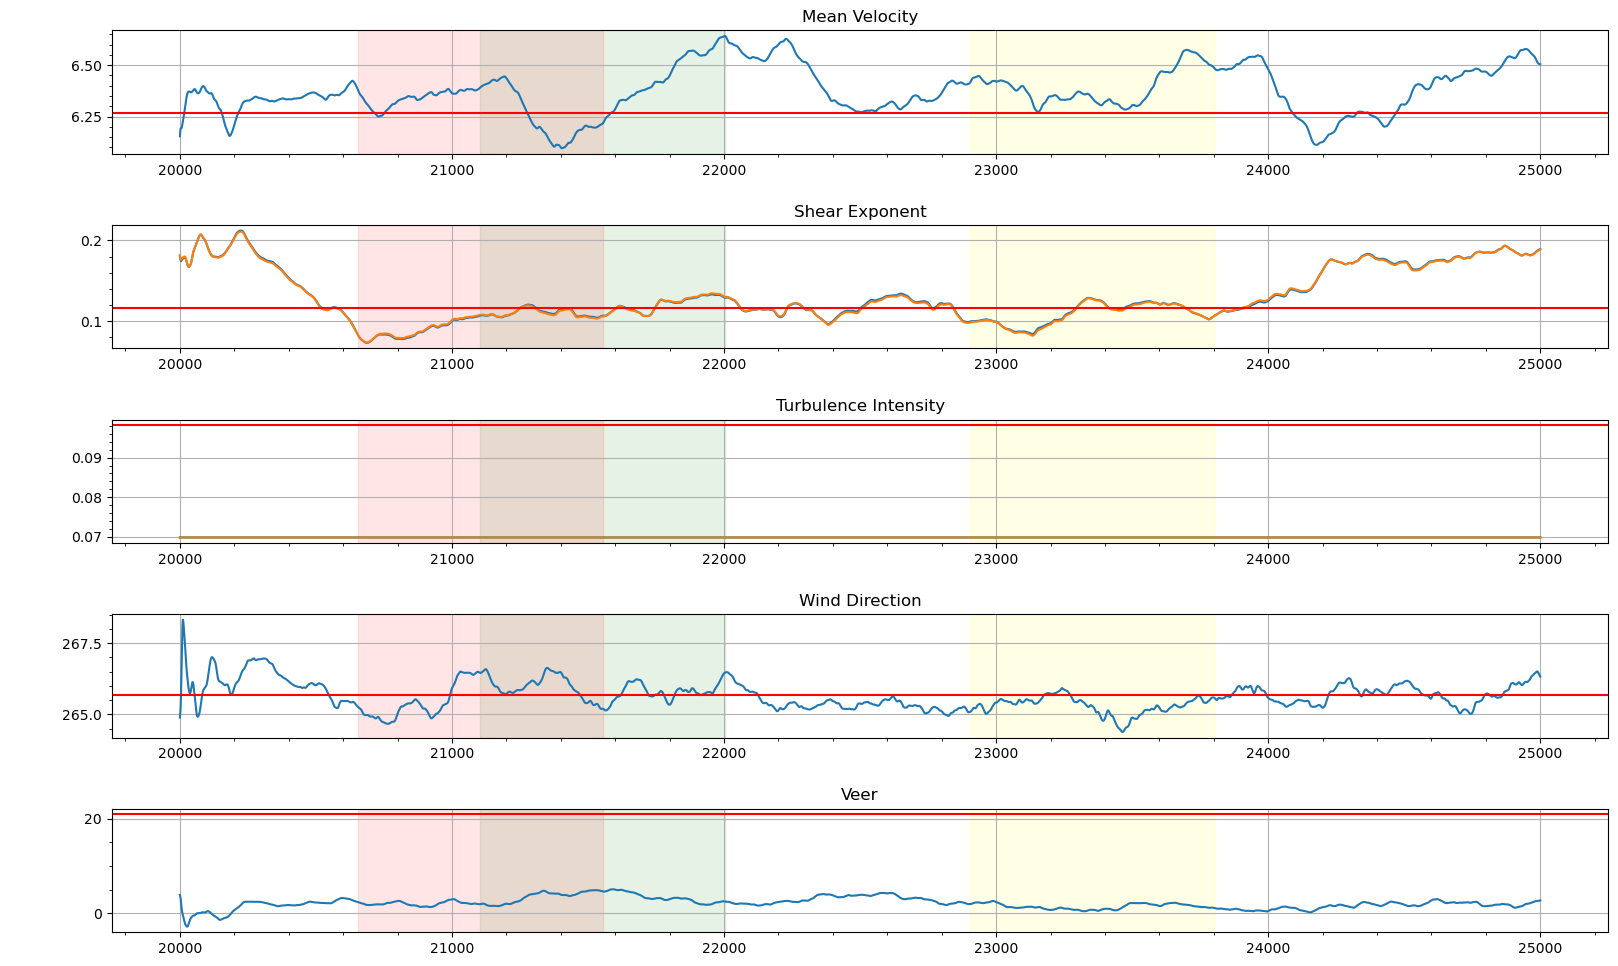

In [8]:
tm = bt*60  #Size of time-windows to average over. Should this also be size of searching window?
best_sep = tm/2.0 #should this be half of tm?
bin_size = bl*dt

plData = {}
plData['Time'] = prT
plData['Umag'] = Umag_hh
plData['Alpha'] = alpha_inst
plData['Alpha-Fit'] = alpha_fit
plData['Veer-Fit'] = veer_fit
plData['WindDir'] = windDir_hh
plData['TI'] = precResTI_inst
maData = pd.DataFrame(plData)


umag_roll = maData['Umag'].rolling(tm,min_periods=1).mean()
alpha_roll = maData['Alpha'].rolling(tm,min_periods=1).mean()
alpha_fit_roll = maData['Alpha-Fit'].rolling(tm,min_periods=1).mean()
veer_fit_roll = maData['Veer-Fit'].rolling(tm,min_periods=1).mean()
ti_ewa = maData['TI'].ewm(alpha=0.005, adjust=False).mean()
ti_roll = maData['TI'].rolling(tm,min_periods=1).mean()
windDir_roll = maData['WindDir'].rolling(tm,min_periods=1).mean()

fig, ax = plt.subplots(5,1, figsize=(16, 10))  

ax[0].plot(prT,umag_roll)
ax[1].plot(prT,alpha_roll)
ax[1].plot(prT,alpha_fit_roll)
ax[2].plot(prT,ti_roll)
ax[2].plot(prT,ti_ewa)
ax[2].plot(prT,maData['TI'],alpha=0.2)
ax[3].plot(prT,windDir_roll)
ax[4].plot(prT,veer_fit_roll)

cbest = np.array([searchDataSort['Time'][0]])
c = 0

for i,s in enumerate(searchDataSort['Time']):
    if c == 0:
        cond1 = (searchDataSort['Time'][i]>(cbest[c]+best_sep))
        cond4 = (searchDataSort['Time'][i]<(cbest[c]-best_sep))
        if( cond1 | cond4):
            cbest = np.append(cbest,searchDataSort['Time'][i])
            c = c + 1
        if(c>=2):
            break
    if c > 0:
        cond1 = (searchDataSort['Time'][i]>(cbest[c]+best_sep))
        cond2 = (searchDataSort['Time'][i]>(cbest[c-1]+best_sep))
        cond3 = (searchDataSort['Time'][i]<(cbest[c]-best_sep))
        cond4 = (searchDataSort['Time'][i]<(cbest[c-1]-best_sep))
        if((cond1 & cond2) | (cond3 & cond4)):
            cbest = np.append(cbest,searchDataSort['Time'][i])
            c = c + 1
        if(c>=2):
            break


print("Best three bins: " + str(cbest))
print("1: Green, 2: Yellow, 3: Red")

for i,a in enumerate(ax):
    a.axvspan(cbest[0], cbest[0]+bin_size, alpha=0.1, color='green')
    a.axvspan(cbest[1], cbest[1]+bin_size, alpha=0.1, color='yellow')
    a.axvspan(cbest[2], cbest[2]+bin_size, alpha=0.1, color='red')
    

#Plot Target parameters
ax[0].axhline(y=expU,color='r')
ax[1].axhline(y=expShear,color='r')
ax[2].axhline(y=expTI,color='r')
ax[3].axhline(y=expWD,color='r')
ax[4].axhline(y=expVeer,color='r')

ax[0].set_title("Mean Velocity")
ax[1].set_title("Shear Exponent")
ax[2].set_title("Turbulence Intensity")
ax[3].set_title("Wind Direction")
ax[4].set_title("Veer")

showplot(0,0)

In [9]:
data = searchDataSort[searchDataSort['Time'].isin(cbest)]
data

,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Veer-Fit,Diff_metric,Umag_Stdev
0,21104.5,6.428745,0.117117,0.117239,0.084788,265.832969,3.587543,0.035432,0.545077
891,22905.0,6.410066,0.116719,0.116091,0.072536,265.423636,0.936455,0.063414,0.464960
3434,20654.0,6.302753,0.105970,0.105957,0.072012,265.827899,3.309801,0.088204,0.453875


In [10]:
ichoice=0
print("Relative Errors")
print("---------------")
print("Alpha-Fit: ",abs(data['Alpha-Fit'][ichoice]-expShear)/abs(expShear))
print("WindDir: ",abs(data['WindDir'][ichoice]-expWD)/abs(expWD))
print("Umean: ",abs(data['Umean'][ichoice]-expU)/abs(expU))
print("Veer-Fit: ",abs(data['Veer-Fit'][ichoice]-expVeer)/abs(expVeer))
print("TI_res: ",abs(data['TI_res'][ichoice]-expTI)/abs(expTI))

Relative Errors
---------------
Alpha-Fit:  0.008772085337569244
WindDir:  0.0006066470285103342
Umean:  0.02613640573639201
Veer-Fit:  0.8283472120210611
TI_res:  0.13676773368106465
